In [64]:
%pwd

'/kaggle/working'

In [76]:
%rm -rf 6D_pose

In [ ]:
%cd /content

In [77]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_rgbd"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 556 (delta 123), reused 134 (delta 63), pack-reused 334 (from 1)
Receiving objects: 100% (556/556), 7.18 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (289/289), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [ ]:
%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [ ]:
%cd ..
%mv Linemod_preprocessed /content

In [ ]:
%pwd

In [ ]:
import sys

sys.path.append("../..")

In [ ]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

In [78]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed_small"
# dataset_root = "/content/Linemod_preprocessed"
dataset_root = "/kaggle/working/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/working/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [9]:
%mv Linemod_preprocessed ./working

In [5]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.3 MB/s eta 0:00:00


In [68]:
from src.pose_rgbd.loss import GeodesicLoss
from src.pose_rgbd.dataset import LineModPoseDepthDataset

train_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="train"
)

test_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="test"
)


 Loaded LineModPoseDepthDataset
   Split: train
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3631
 Loaded LineModPoseDepthDataset
   Split: test
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 20528


In [69]:
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
print(f"Depth shape: {sample['depth'].shape}")
print(f"RGB shape: {sample['image'].shape}")

Sample keys: dict_keys(['image', 'depth', 'img_id', 'img_path', 'rotation', 'translation', '3D_center', 'object_id', 'class_idx', 'cam_K', 'bbox'])
Depth shape: torch.Size([1, 224, 224])
RGB shape: torch.Size([3, 224, 224])


In [88]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [95]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
# from src.pose_rgbd.model import RotationPredictionModel
from src.pose_rgbd.model import RGBDRotationModel
from src.pose_rgbd.dataset import LineModPoseDepthDataset
from src.pose_rgbd.loss import GeodesicLoss


# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [96]:
from utils.linemod_config import get_linemod_config
import numpy as np
import torch

# dataset_root = "../../Linemod_preprocessed_small"  # Adjust path as needed
linemod_config = get_linemod_config(dataset_root)

all_model_points = []
NUM_POINTS = 1000  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx

In [97]:
all_model_points.shape

torch.Size([13, 1000, 3])

In [101]:
from src.pose_rgbd.loss import MultiObjectPointMatchingLoss

model = RGBDRotationModel(pretrained=True)
model = model.to(device)

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = Adam(model.parameters(), lr=1e-4)

In [102]:
from tqdm import tqdm
import os
import datetime
from itertools import islice
from datetime import datetime

# Load best model

# Ciclo di training
num_epochs = 50
best_test_loss = float('inf')
# checkpoint_dir = "checkpoints"
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# checkpoint_dir = f'/content/drive/MyDrive/runs/POINT_MATCH_{timestamp}' # modify here for kaggle
checkpoint_dir = f'/kaggle/working/POINT_MATCH_{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)
val_batches_limit = 50

# Track losses for plotting
train_losses = []
test_losses = []

batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for batch in train_pbar:
        rgb = batch['image'].to(device)  # RGB image (B, 3, H, W)
        depth = batch['depth'].to(device)  # Depth (B, 1, H, W)
        rotations = batch['rotation'].to(device)  # GT quaternion (B, 4)
        obj_ids = batch['object_id'].to(device)  # Object IDs (B,)
        obj_ids = obj_id_to_idx[obj_ids]  # Map to indices (B,)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(rgb, depth)

        # Calcolo della loss
        loss = criterion(outputs, rotations, obj_ids)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_pbar.set_postfix({'loss': epoch_loss / (train_pbar.n + 1)})

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0

    val_iterator = islice(test_loader, val_batches_limit)
    val_pbar = tqdm(val_iterator, total=val_batches_limit, desc="Validating")
    count_batches = 0
    with torch.no_grad():
        for batch in val_pbar:
            rgb = batch['image'].to(device)
            depth = batch['depth'].to(device)
            rotations = batch['rotation'].to(device)
            obj_ids = batch['object_id'].to(device)  # Object IDs (B,)
            obj_ids = obj_id_to_idx[obj_ids].to(device)  # Map to indices (B,)

            outputs = model(rgb, depth)
            loss = criterion(outputs, rotations, obj_ids)
            test_loss += loss.item()
            val_pbar.set_postfix({'loss': test_loss / (val_pbar.n + 1)})
            count_batches+=1

    avg_test_loss = test_loss / count_batches if count_batches > 0 else 0
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

    # Save checkpoint if test loss improved
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': avg_test_loss,
        }, checkpoint_path)
        print(f"✅ Checkpoint saved! Best Test Loss: {best_test_loss:.4f}")
    else:
        print(f"⚠️  No improvement. Best Test Loss: {best_test_loss:.4f}")

Validating: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s, loss=0.039] 


Epoch [1/50], Test Loss: 0.0390
✅ Checkpoint saved! Best Test Loss: 0.0390


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s, loss=0.0327]


Epoch [2/50], Test Loss: 0.0327
✅ Checkpoint saved! Best Test Loss: 0.0327


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s, loss=0.0298]


Epoch [3/50], Test Loss: 0.0298
✅ Checkpoint saved! Best Test Loss: 0.0298


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s, loss=0.0241]


Epoch [4/50], Test Loss: 0.0241
✅ Checkpoint saved! Best Test Loss: 0.0241


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s, loss=0.0222]


Epoch [5/50], Test Loss: 0.0222
✅ Checkpoint saved! Best Test Loss: 0.0222


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, loss=0.0238]


Epoch [6/50], Test Loss: 0.0238
⚠️  No improvement. Best Test Loss: 0.0222


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s, loss=0.0234]


Epoch [7/50], Test Loss: 0.0234
⚠️  No improvement. Best Test Loss: 0.0222


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, loss=0.019] 


Epoch [8/50], Test Loss: 0.0190
✅ Checkpoint saved! Best Test Loss: 0.0190


Validating: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s, loss=0.0175]


Epoch [9/50], Test Loss: 0.0175
✅ Checkpoint saved! Best Test Loss: 0.0175


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s, loss=0.017] 


Epoch [10/50], Test Loss: 0.0170
✅ Checkpoint saved! Best Test Loss: 0.0170


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, loss=0.0175]


Epoch [11/50], Test Loss: 0.0175
⚠️  No improvement. Best Test Loss: 0.0170


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s, loss=0.015] 


Epoch [12/50], Test Loss: 0.0150
✅ Checkpoint saved! Best Test Loss: 0.0150


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, loss=0.0141]


Epoch [13/50], Test Loss: 0.0141
✅ Checkpoint saved! Best Test Loss: 0.0141


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s, loss=0.0135]


Epoch [14/50], Test Loss: 0.0135
✅ Checkpoint saved! Best Test Loss: 0.0135


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s, loss=0.0158]


Epoch [15/50], Test Loss: 0.0158
⚠️  No improvement. Best Test Loss: 0.0135


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, loss=0.0163]


Epoch [16/50], Test Loss: 0.0163
⚠️  No improvement. Best Test Loss: 0.0135


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, loss=0.0147]


Epoch [17/50], Test Loss: 0.0147
⚠️  No improvement. Best Test Loss: 0.0135


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s, loss=0.015] 


Epoch [18/50], Test Loss: 0.0150
⚠️  No improvement. Best Test Loss: 0.0135


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, loss=0.0124] 


Epoch [19/50], Test Loss: 0.0124
✅ Checkpoint saved! Best Test Loss: 0.0124


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s, loss=0.0134]


Epoch [20/50], Test Loss: 0.0134
⚠️  No improvement. Best Test Loss: 0.0124


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, loss=0.0124] 


Epoch [21/50], Test Loss: 0.0124
⚠️  No improvement. Best Test Loss: 0.0124


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s, loss=0.0116] 


Epoch [22/50], Test Loss: 0.0116
✅ Checkpoint saved! Best Test Loss: 0.0116


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, loss=0.0115] 


Epoch [23/50], Test Loss: 0.0115
✅ Checkpoint saved! Best Test Loss: 0.0115


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, loss=0.0119] 


Epoch [24/50], Test Loss: 0.0119
⚠️  No improvement. Best Test Loss: 0.0115


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s, loss=0.0113]


Epoch [25/50], Test Loss: 0.0113
✅ Checkpoint saved! Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, loss=0.0129]


Epoch [26/50], Test Loss: 0.0129
⚠️  No improvement. Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s, loss=0.0128]


Epoch [27/50], Test Loss: 0.0128
⚠️  No improvement. Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, loss=0.014] 


Epoch [28/50], Test Loss: 0.0140
⚠️  No improvement. Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s, loss=0.014] 


Epoch [29/50], Test Loss: 0.0140
⚠️  No improvement. Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s, loss=0.0122]


Epoch [30/50], Test Loss: 0.0122
⚠️  No improvement. Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s, loss=0.0113] 


Epoch [31/50], Test Loss: 0.0113
⚠️  No improvement. Best Test Loss: 0.0113


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, loss=0.0106] 


Epoch [32/50], Test Loss: 0.0106
✅ Checkpoint saved! Best Test Loss: 0.0106


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, loss=0.0109] 


Epoch [33/50], Test Loss: 0.0109
⚠️  No improvement. Best Test Loss: 0.0106


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, loss=0.0111] 


Epoch [34/50], Test Loss: 0.0111
⚠️  No improvement. Best Test Loss: 0.0106


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.18it/s, loss=0.0101] 


Epoch [35/50], Test Loss: 0.0101
✅ Checkpoint saved! Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s, loss=0.0103] 


Epoch [36/50], Test Loss: 0.0103
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.25it/s, loss=0.0116]


Epoch [37/50], Test Loss: 0.0116
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s, loss=0.0115] 


Epoch [38/50], Test Loss: 0.0115
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, loss=0.0105] 


Epoch [39/50], Test Loss: 0.0105
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.22it/s, loss=0.011]  


Epoch [40/50], Test Loss: 0.0110
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s, loss=0.0132]


Epoch [41/50], Test Loss: 0.0132
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s, loss=0.0136]


Epoch [42/50], Test Loss: 0.0136
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, loss=0.0159]


Epoch [43/50], Test Loss: 0.0159
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s, loss=0.0168]


Epoch [44/50], Test Loss: 0.0168
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.27it/s, loss=0.0141]


Epoch [45/50], Test Loss: 0.0141
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s, loss=0.0161]


Epoch [46/50], Test Loss: 0.0161
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, loss=0.0147]


Epoch [47/50], Test Loss: 0.0147
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s, loss=0.0128] 


Epoch [48/50], Test Loss: 0.0128
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s, loss=0.011]  


Epoch [49/50], Test Loss: 0.0110
⚠️  No improvement. Best Test Loss: 0.0101


Validating: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s, loss=0.0123] 

Epoch [50/50], Test Loss: 0.0123
⚠️  No improvement. Best Test Loss: 0.0101


✅ Plot saved: /kaggle/working/POINT_MATCH_20251219_175916/loss_comparison.png


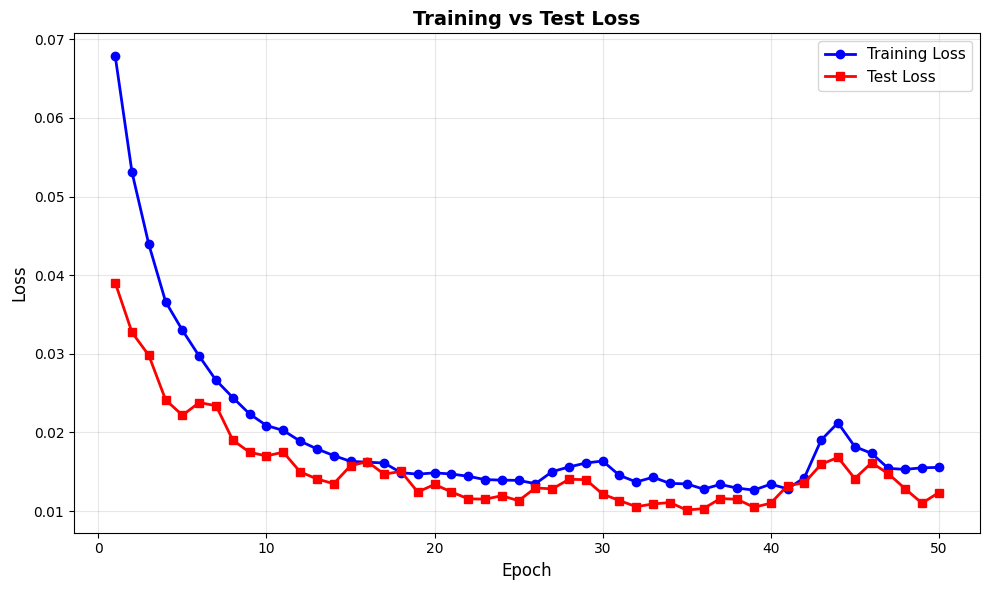

✅ Plot saved: /kaggle/working/POINT_MATCH_20251219_175916/training_loss.png


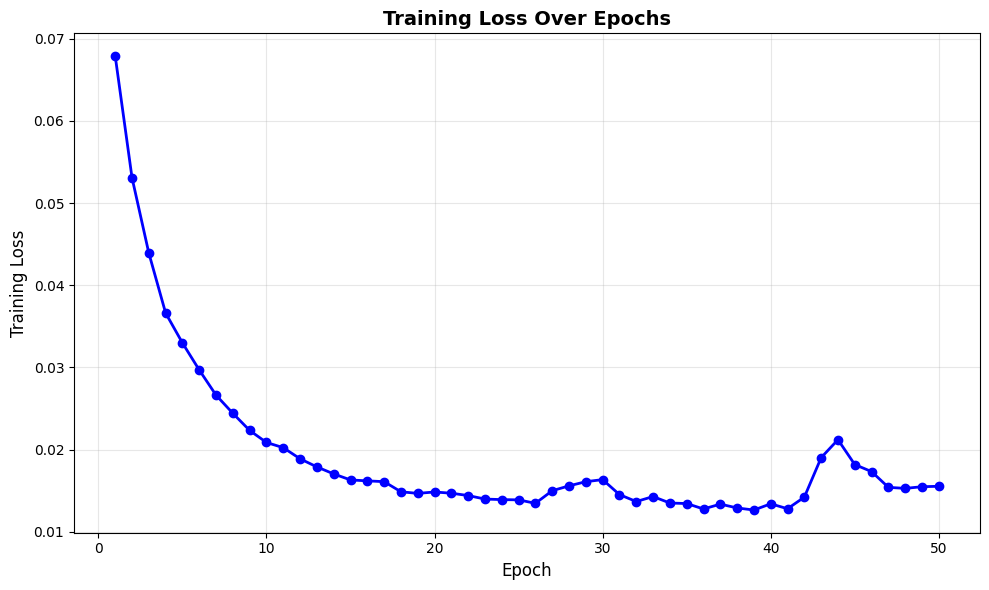

✅ Plot saved: /kaggle/working/POINT_MATCH_20251219_175916/test_loss.png


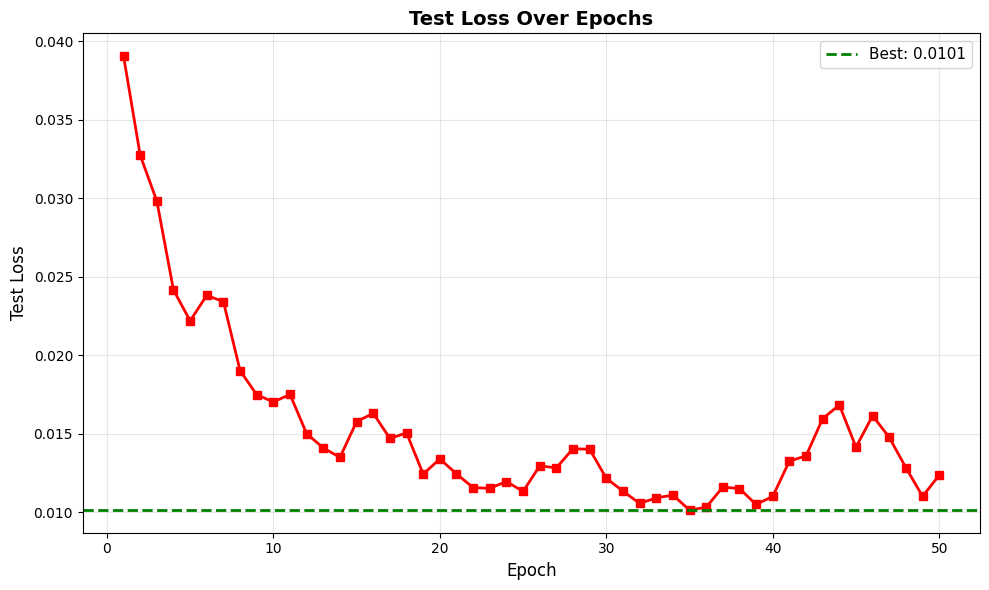


✅ All plots saved in '/kaggle/working/POINT_MATCH_20251219_175916' directory!


In [103]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(test_losses)+1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [104]:
# Save losses
import pickle


losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

✅ Loaded best model from epoch 34 with test loss: 0.0101

📷 Visualizing sample 9638:
   Object ID: 4
   Image ID: 503

📊 Ground Truth vs Prediction:
   GT Rotation: [ 0.5630956   0.810923    0.08804497 -0.132572  ]
   Pred Rotation: [ 0.60134745  0.78646773  0.11803799 -0.07692035]
   GT Translation: [-0.01779818 -0.01831111  1.0249983 ]

✅ Visualization saved!


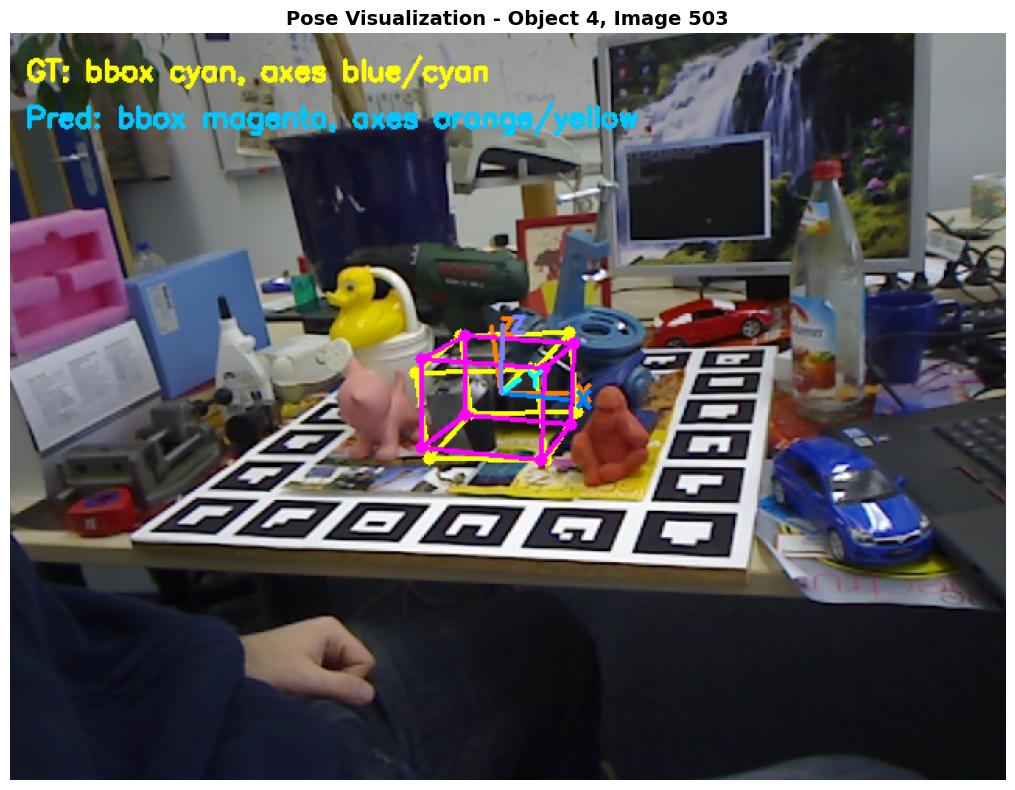

In [39]:
import random
import cv2
from utils.projection_utils import setup_projection_utils, visualize_pose_comparison, get_image
import matplotlib.pyplot as plt

# Setup projection utils
setup_projection_utils(dataset_root)

# Load best model
best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']} with test loss: {checkpoint['test_loss']:.4f}")

# Select a random sample from test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[random_idx]

print(f"\n📷 Visualizing sample {random_idx}:")
print(f"   Object ID: {sample['object_id']}")
print(f"   Image ID: {sample['img_id']}")

# Get the original image
img_path = sample['img_path']
image_rgb = cv2.imread(str(img_path))
# image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# Prepare input for model
rgb = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
depth = sample['depth'].unsqueeze(0).to(device)  # Add batch and channel dimensions

# Get model prediction
model.eval()
with torch.no_grad():
    pred_rotation = model(rgb, depth)[0].cpu().numpy()

# Get ground truth
gt_rotation = sample['rotation'].numpy()
gt_translation = sample['translation'].numpy()

# Get camera intrinsics
cam_K = sample['cam_K'].numpy()

print(f"\n📊 Ground Truth vs Prediction:")
print(f"   GT Rotation: {gt_rotation}")
print(f"   Pred Rotation: {pred_rotation}")
print(f"   GT Translation: {gt_translation}")

# Visualize pose comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
img_vis = visualize_pose_comparison(
    image_rgb,
    object_id=sample['object_id'],
    cam_K=cam_K,
    gt_rotation=gt_rotation,
    gt_translation=gt_translation,
    pred_rotation=pred_rotation,
    pred_translation=gt_translation  # Using GT translation for now
)

# Convert BGR to RGB for matplotlib
img_vis_rgb = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
ax.imshow(img_vis_rgb)
ax.axis('off')
ax.set_title(f"Pose Visualization - Object {sample['object_id']}, Image {sample['img_id']}", fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig(os.path.join(plots_dir, f"pose_visualization_sample_{random_idx}.png"), dpi=150, bbox_inches='tight')
print(f"\n✅ Visualization saved!")
plt.show()

In [105]:
#### import torch
import numpy as np
import os
import trimesh
from collections import defaultdict
from tqdm.auto import tqdm
from metrics.ADD_metric import compute_ADD_metric_quaternion
from src.pose_rgbd.model import RGBDRotationModel

# ==========================================
# 1. CARICAMENTO DATI E DIAMETRI
# ==========================================
def load_models_info(models_dir, obj_ids, num_points=1000):
    """
    Carica i punti e calcola il DIAMETRO di ogni oggetto.
    Restituisce:
      - point_cache: {id: punti_m}
      - diameters: {id: diametro_m}
    """
    point_cache = {}
    diameters = {}
    
    unique_ids = list(set(obj_ids))
    print(f"⏳ Caricamento info per {len(unique_ids)} modelli...")
    
    for oid in tqdm(unique_ids, desc="Mesh Analysis"):
        filename = f"obj_{int(oid):02d}.ply"
        path = os.path.join(models_dir, filename)
        
        if os.path.exists(path):
            mesh = trimesh.load(path)
            
            # 1. Punti per ADD
            points, _ = trimesh.sample.sample_surface(mesh, num_points)
            point_cache[oid] = points / 1000.0 # Metri
            
            # 2. Calcolo Diametro (Distanza massima tra due vertici o diagonale bbox)
            # Metodo standard LineMod: Diagonale della Bounding Box
            extents = mesh.extents / 1000.0 # Metri
            diameter = np.linalg.norm(extents)
            diameters[oid] = diameter
        else:
            print(f"⚠️ Modello mancante: {path}")
            
    return point_cache, diameters

# ==========================================
# 2. VALUTAZIONE IBRIDA (ERROR + ACCURACY)
# ==========================================
def evaluate_comprehensive(model_rot, dataloader, device, models_dir, model_trans=None):
    model_rot.eval()
    if model_trans: model_trans.eval()
    
    # Raccogli ID e carica dati
    all_obj_ids = [1,2,4,5,6,8,9,10,11,12,13,14,15]
    points_dict, diameters_dict = load_models_info(models_dir, all_obj_ids)
    
    # Strutture dati
    # errors_dict: lista di errori in metri per ogni oggetto
    # correct_preds: contatore di quante volte errore < 0.1 * diametro
    # total_preds: contatore totale campioni
    errors_dict = defaultdict(list)
    accuracy_stats = defaultdict(lambda: {"correct": 0, "total": 0})
    
    print("\n🚀 Avvio Benchmark Completo (ADD Error + ADD-0.1d Accuracy)...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            imgs = batch['image'].to(device)
            depths = batch['depth'].to(device)
            gt_quats = batch['rotation'].to(device)
            gt_trans = batch['translation'].to(device)
            obj_ids = batch['object_id']
            
            pred_quats = model_rot(imgs, depths)
            
            # if model_trans:
            #     if 'bbox_info' in batch:
            #         bbox_info = batch['bbox_info'].to(device)
            #         pred_trans_batch = model_trans(imgs, bbox_info)
            #     else:
            #         pred_trans_batch = gt_trans
            # else:
            #     pred_trans_batch = gt_trans # Fallback GT

            # Loop sui singoli sample
            batch_size = imgs.shape[0]
            for i in range(batch_size):
                curr_id = int(obj_ids[i])
                if curr_id not in points_dict: continue
                
                # Calcola ADD Error (Metri)
                add_error = compute_ADD_metric_quaternion(
                    model_points=points_dict[curr_id],
                    gt_quat=gt_quats[i].cpu().numpy(),
                    gt_translation=gt_trans[i].cpu().numpy(),
                    pred_quat=pred_quats[i].cpu().numpy(),
                    pred_translation=gt_trans[i].cpu().numpy()
                )
                
                # Salva errore assoluto
                errors_dict[curr_id].append(add_error)
                
                # --- CALCOLO ACCURACY (La parte nuova) ---
                # Soglia = 10% del diametro
                threshold = diameters_dict[curr_id] * 0.1
                
                accuracy_stats[curr_id]["total"] += 1
                if add_error < threshold:
                    accuracy_stats[curr_id]["correct"] += 1

    # ==========================================
    # 3. REPORT FINALE (CONFRONTABILE)
    # ==========================================
    print("\n" + "="*85)
    print(f"{'ID':<3} | {'DIAMETER':<10} | {'ADD ERROR (cm)':<15} | {'ACCURACY (ADD-0.1d)':<20} | {'SAMPLES':<8}")
    print("="*85)
    
    total_acc_correct = 0
    total_acc_count = 0
    
    sorted_ids = sorted(errors_dict.keys())
    for oid in sorted_ids:
        # Error stats
        mean_err_m = np.mean(errors_dict[oid])
        mean_err_cm = mean_err_m * 100
        
        # Accuracy stats
        stats = accuracy_stats[oid]
        acc_perc = (stats["correct"] / stats["total"]) * 100
        
        total_acc_correct += stats["correct"]
        total_acc_count += stats["total"]
        
        diam_cm = diameters_dict[oid] * 100
        
        print(f"{oid:<3} | {diam_cm:.1f} cm     | {mean_err_cm:.2f} cm          | {acc_perc:.2f} %               | {stats['total']}")
        
    print("="*85)
    global_acc = (total_acc_correct / total_acc_count) * 100
    print(f"🏆 MEDIA TOTALE: Errore Medio = ??? cm | Accuratezza Globale = {global_acc:.2f} %")
    print("="*85)

# --- USO ---
MODELS_ROOT = '/kaggle/working/Linemod_preprocessed/models'

data = torch.load(checkpoint_dir + "/best_model.pth")

model = RGBDRotationModel()
model.load_state_dict(data['model_state_dict'])
model.to(device)


evaluate_comprehensive(model, test_loader, device, MODELS_ROOT, model_trans=None)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [58]:
# /kaggle/output/Linemod_preprocessed/models/obj_15.ply
%ls /kaggle/working/Linemod_preprocessed/models

models_info.yml*  obj_04.ply*  obj_08.ply*  obj_12.ply*
obj_01.ply*       obj_05.ply*  obj_09.ply*  obj_13.ply*
obj_02.ply*       obj_06.ply*  obj_10.ply*  obj_14.ply*
obj_03.ply*       obj_07.ply*  obj_11.ply*  obj_15.ply*


<All keys matched successfully>